<a href="https://colab.research.google.com/github/formroller/ML_clone/blob/master/kaggle/HousePrice/HousePrice_Predict(ko).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[HousePrice Tutorial - 캐글 집값 예측](https://www.kaggle.com/kongnyooong/house-price-tutorial-for-korean-beginners)

이전 Predict는 변수 튜닝과정에서 지수와 가중치 등을 임의로 조절하는 부분의 이해가 어렵고 중간 중간 난해한 부분이 많아 필사를 중단하고 해당 예측을 필사하려 한다.  
  이번 과정에서는 train, test 데이터 전처리, train 데이터 훈련 과정과 그를 통한 test 적용, 예측 과정 수행에 중점을 두고 필사하고자 한다.

# 들어가기 전에

1. **대회 소개**  
 아이오와 주 에임스에 있는 주거용 주택의 모든 측면을 설명하는 79개의 변수로 주택의 판매가격을 예측하는 Competition이다. 
2. 커널 순서
        1. Import & Data Check
            - 데이터 확인
            - 이상치 탐색 및 제거
            - 결측 데이터 확인
            - Skewness(비대칭도) 확인
        2. EDA
            - Numerical Data 탐색
            - Categorical Data 탐색
        3. Feature Engineering
            - Log 변환
            - 결측 데이터 처리
            - 유의하지 않은 변수 삭제
            - Categorical Data 수치형 변환
        4. Modeling & make submission
            - Model: XGBoost
            - Submission
문제를 보기 전에 Data에 대한 이해를 한번 해보시는게 훨씬 쉽게 다가올 수 있습니다.
Competition main에 가서 Data에 대한 설명을 읽고 오시면 도움이 많이 될 것입니다.

#1.Improt & Data check

In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from collections import Counter

plt.style.use('seaborn')
sns.set(font_scale=1.5)

import missingno as msno

import warnings
warnings.filterwarnings('ignore')

In [2]:
os.chdir('/content/drive/MyDrive/kaggle/HousePrice')

In [3]:
df_train=pd.read_csv('train.csv')
df_test=pd.read_csv('test.csv')

## 1)데이터 확인

In [4]:
df_train.head() 

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,...,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,...,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,...,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,...,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,...,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,...,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [5]:
df_train.shape, df_test.shape

((1460, 81), (1459, 80))

In [6]:
# 수치형, 범주형 변수 분리
numerical_feats=df_train.dtypes[df_train.dtypes != 'object'].index
print(f"Number of Numerical features : {len(numerical_feats)}")

categorical_feats=df_train.dtypes[df_train.dtypes == 'object'].index
print(f"Number of Categorical features : {len(categorical_feats)}")

Number of Numerical features : 38
Number of Categorical features : 43


In [7]:
print('Numeric \n',df_train[numerical_feats].columns)
print('*'*80)
print('Categorical \n',df_train[categorical_feats].columns)

Numeric 
 Index(['Id', 'MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual',
       'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd',
       'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF',
       'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea',
       'MiscVal', 'MoSold', 'YrSold', 'SalePrice'],
      dtype='object')
********************************************************************************
Categorical 
 Index(['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Founda

## 2)이상치 탐색 및 제거

In [8]:
# train 데이터의 이상치 탐색
# IQR(튜키의 방법)을 이요한 함수를 지정해 이상치 탐색 수행.

def detect_outliers(df,n,features):
    outlier_indices=[]
    for col in features:
        Q1=np.percentile(df[col],25)
        Q3=np.percentile(df[col],75)
        IQR=Q3-Q1

        outlier_step=1.5*IQR

        outlier_list_col=df[(df[col]<Q1-outlier_step)|(df[col]>Q3+outlier_step)].index
        outlier_indices.extend(outlier_list_col)
        outlier_indices=Counter(outlier_indices)
        multiple_outliers=list(k for k,v in outlier_indices.items() if v > n)

        return multiple_outliers

Outliers_to_drop=detect_outliers(df_train,2,['Id', 'MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual',
       'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd',
       'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF',
       'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea',
       'MiscVal', 'MoSold', 'YrSold', 'SalePrice'])


In [9]:
# 이상치가 발견된 행을 확인한다.
df_train.loc[Outliers_to_drop]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,...,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice


In [10]:
# 이상치들을 제거하고 결과를 확인한다.
# 행의 수가 1338개로 줄어든다. 

df_train=df_train.drop(Outliers_to_drop, axis=0).reset_index(drop=True)
df_train.shape

(1460, 81)

## 3)결측치 확인

In [11]:
for col in df_train:
    msperce='column:{:>10}\t Percent of NaN value : {:.2f}%'.format(col, 100*(df_train[col].isnull().sum()/df_train[col].shape[0]))
    print(msperce)

# train데이터 각 column의 결측치가 몇 %인지 확인한다. 
# df_train[col].isnull().com() : 해당 열의 결측치가 몇개인지 알 수 있게 하는 문장이다. (True=1(결측치)/False=0으로 계산)
# df_train[col].shape[0] : 해당 열의 차원 (열이 지정되어 있으므로 행의 갯수를 보여준다.)
# 100*(df_train[col].isnull()/df_train[col].shape[0]):위 설명을 통해 %를 출력해주는 문장인 것을 알 수 있다.

column:        Id	 Percent of NaN value : 0.00%
column:MSSubClass	 Percent of NaN value : 0.00%
column:  MSZoning	 Percent of NaN value : 0.00%
column:LotFrontage	 Percent of NaN value : 17.74%
column:   LotArea	 Percent of NaN value : 0.00%
column:    Street	 Percent of NaN value : 0.00%
column:     Alley	 Percent of NaN value : 93.77%
column:  LotShape	 Percent of NaN value : 0.00%
column:LandContour	 Percent of NaN value : 0.00%
column: Utilities	 Percent of NaN value : 0.00%
column: LotConfig	 Percent of NaN value : 0.00%
column: LandSlope	 Percent of NaN value : 0.00%
column:Neighborhood	 Percent of NaN value : 0.00%
column:Condition1	 Percent of NaN value : 0.00%
column:Condition2	 Percent of NaN value : 0.00%
column:  BldgType	 Percent of NaN value : 0.00%
column:HouseStyle	 Percent of NaN value : 0.00%
column:OverallQual	 Percent of NaN value : 0.00%
column:OverallCond	 Percent of NaN value : 0.00%
column: YearBuilt	 Percent of NaN value : 0.00%
column:YearRemodAdd	 Percent of 

In [12]:
# test 데이터 확인
# train,test 모두 PoolQc데이터의 결측치가 가장 많다.
for col in df_test.columns:
    msperc='column : {:>10}\t Percent of NaN values : {:.2f}%'.format(col,100*(df_test[col].isnull().sum()/df_test[col].shape[0]))
    print(msperc)

column :         Id	 Percent of NaN values : 0.00%
column : MSSubClass	 Percent of NaN values : 0.00%
column :   MSZoning	 Percent of NaN values : 0.27%
column : LotFrontage	 Percent of NaN values : 15.56%
column :    LotArea	 Percent of NaN values : 0.00%
column :     Street	 Percent of NaN values : 0.00%
column :      Alley	 Percent of NaN values : 92.67%
column :   LotShape	 Percent of NaN values : 0.00%
column : LandContour	 Percent of NaN values : 0.00%
column :  Utilities	 Percent of NaN values : 0.14%
column :  LotConfig	 Percent of NaN values : 0.00%
column :  LandSlope	 Percent of NaN values : 0.00%
column : Neighborhood	 Percent of NaN values : 0.00%
column : Condition1	 Percent of NaN values : 0.00%
column : Condition2	 Percent of NaN values : 0.00%
column :   BldgType	 Percent of NaN values : 0.00%
column : HouseStyle	 Percent of NaN values : 0.00%
column : OverallQual	 Percent of NaN values : 0.00%
column : OverallCond	 Percent of NaN values : 0.00%
column :  YearBuilt	 Pe

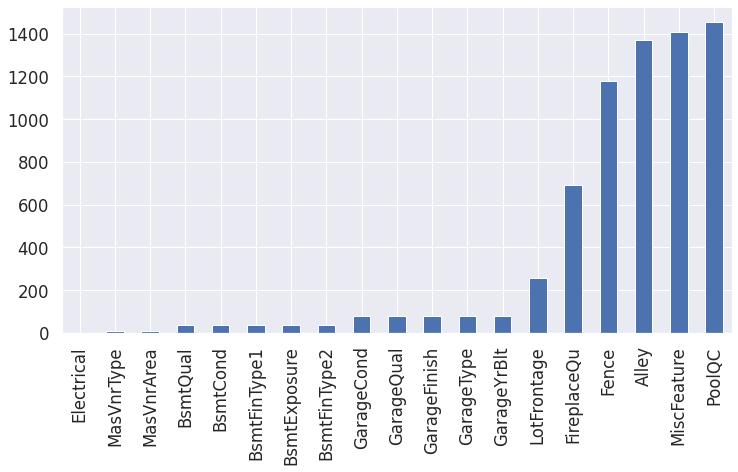

In [13]:
# 직관적인 확인을 위해 barplot 그려본다.
missing=df_train.isnull().sum()
missing=missing[missing>0]
missing.sort_values(inplace=True)
missing.plot.bar(figsize=(12,6))

## 4)Skewness(비대칭도) 확인

* 수치형 변수의 Skewness(비대칭도), Kurtosis(첨도)를 확인한다.  
* 이는 분포가 얼마나 비대칭을 알려주는 척도이다(비대칭도: a=0이면 정규분표, <u>a<0이면 오른쪽</u>으로 치우침,  <u>a>0이면 왼쪽으로</u> 치우침.
* 비대칭도와 첨도를 띄는 변수가 여럿 보인다. Target Feature인 'SalePrice' 또한 약간의 정도를 보인는 것으로 보인다. 

In [14]:
for col in numerical_feats:
    print('{:15}'.format(col),
          'Skewness : {:05.2f}'.format(df_train[col].skew()),
          '        ',
          'Kurtosis : {:06.2f}'.format(df_train[col].kurt())
          )

Id              Skewness : 00.00          Kurtosis : -01.20
MSSubClass      Skewness : 01.41          Kurtosis : 001.58
LotFrontage     Skewness : 02.16          Kurtosis : 017.45
LotArea         Skewness : 12.21          Kurtosis : 203.24
OverallQual     Skewness : 00.22          Kurtosis : 000.10
OverallCond     Skewness : 00.69          Kurtosis : 001.11
YearBuilt       Skewness : -0.61          Kurtosis : -00.44
YearRemodAdd    Skewness : -0.50          Kurtosis : -01.27
MasVnrArea      Skewness : 02.67          Kurtosis : 010.08
BsmtFinSF1      Skewness : 01.69          Kurtosis : 011.12
BsmtFinSF2      Skewness : 04.26          Kurtosis : 020.11
BsmtUnfSF       Skewness : 00.92          Kurtosis : 000.47
TotalBsmtSF     Skewness : 01.52          Kurtosis : 013.25
1stFlrSF        Skewness : 01.38          Kurtosis : 005.75
2ndFlrSF        Skewness : 00.81          Kurtosis : -00.55
LowQualFinSF    Skewness : 09.01          Kurtosis : 083.23
GrLivArea       Skewness : 01.37        

# 2.EDA


## Numerical Data 탐색

수치형 데이터들을 알아보기 위해 다음 4가지 Plot을 그린다.
* Correlation Heat Map
* Zoomed Heat Map
* Pair Plot
* Scatter Plot

### 1)Correlation Heat Map

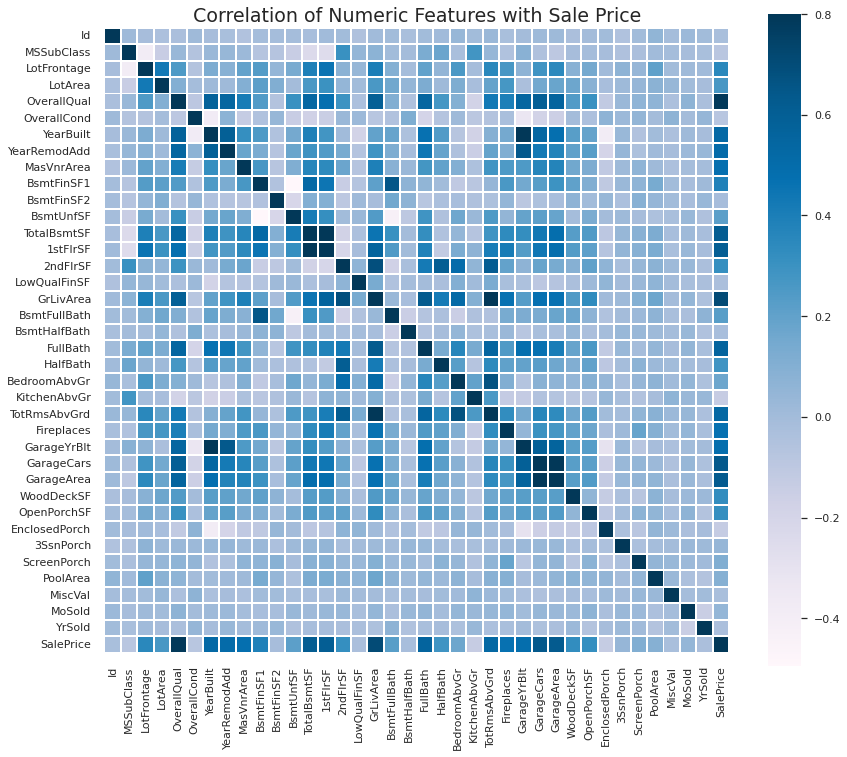

In [15]:
corr_data= df_train[['Id', 'MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual',
       'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd',
       'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF',
       'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea',
                      'MiscVal', 'MoSold', 'YrSold', 'SalePrice']]

colormap=plt.cm.PuBu
sns.set(font_scale=1.0)

f,ax=plt.subplots(figsize=(14,12))
plt.title('Correlation of Numeric Features with Sale Price', y=1,size=19)
sns.heatmap(corr_data.corr(), square=True, linewidths=01., cmap=colormap, linecolor='white',vmax=0.8)

* Heat Map은 변수 간 상관관계에 대해 쉽게 알 수 있으며 변수 간 다중 공선성을 감지하는데 유용하다.   
* 대각선 열을 제외한 박스 중 가잔 진한 파란색을 띄는 박스를 보여준다. 첫번째는 'TotalBamtSF'와 '1sstFlrSF'변수의 관계이고 두번째는 'Garage'와 관련한 변수를 나타낸다.  
* 두 경우 모두 변수 사이의 상관 관계가 너무 강해 *다중 공선성*(MultiColarisity)상황이 나타날 수 있다. 
* 변수가 거의 동일한 정보를 제공하므로 다중 공선성이 발생한다는 결론을 낼 수 있다. 
* 또한 확인해야 할 부분은 'SalePrice'와의 상관 관계이다. 
* 'GrLivArea', 'TotalBsmtSF' 및 'OverallQual'은 큰 관계를 보인다.
* 나머지 변수와의 상관 관계를 자세히 알아보기 위해 Zoomed Heat Map을 확인한다.

### 2)Zoomed Heat Map

Index(['SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars', 'GarageArea',
       'TotalBsmtSF', '1stFlrSF', 'FullBath', 'TotRmsAbvGrd', 'YearBuilt',
       'YearRemodAdd'],
      dtype='object')


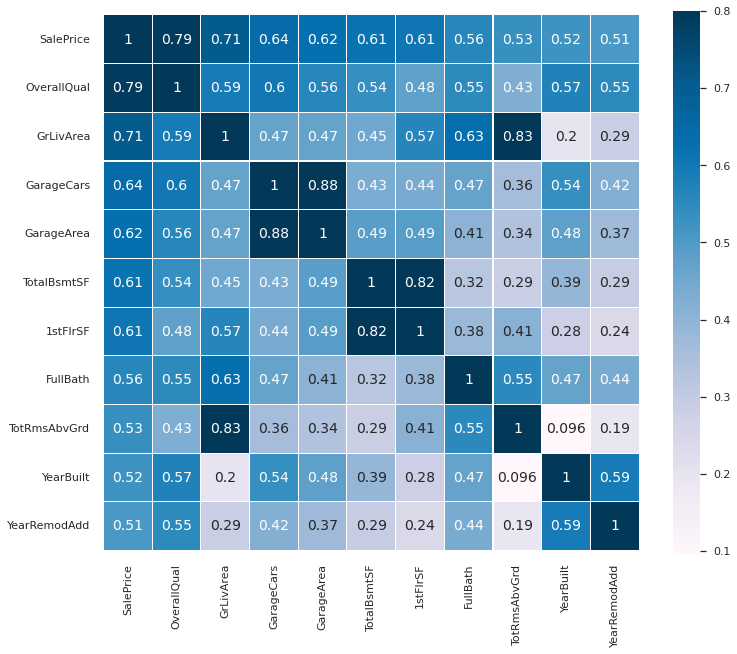

In [16]:
k=11
cols=corr_data.corr().nlargest(k,'SalePrice')['SalePrice'].index
print(cols)
cm=np.corrcoef(df_train[cols].values.T)
g,ax=plt.subplots(figsize=(12,10))
sns.heatmap(cm, vmax=.8, linewidths=0.1, square=True, annot=True, cmap=colormap,
            linecolor='white',xticklabels=cols.values, annot_kws={'size':14}, yticklabels=cols.values)

* 가장 눈에 띄는 GarageCars와 GarageArea, TotalBsmtSF와 1stFlrSF는 서로 밀접하게 연관되어 있는 것을 알 수 있다.
* Target Feature와 가장 밀접한 연관이 있는 feature는 'OverallQual', 'GrLivArea' 및 'TotalBsmtSF'로 보인다.
* 먼저 말했던 GarageCars와 GarageArea, TotalBsmtSF, GrLivArea를 남기고 나머지는 이후에 버리도록 하자.
* SalePrice와 연관을 더 알아보기 위해 PairPlot을 그려본다.


### 3)PairPlot

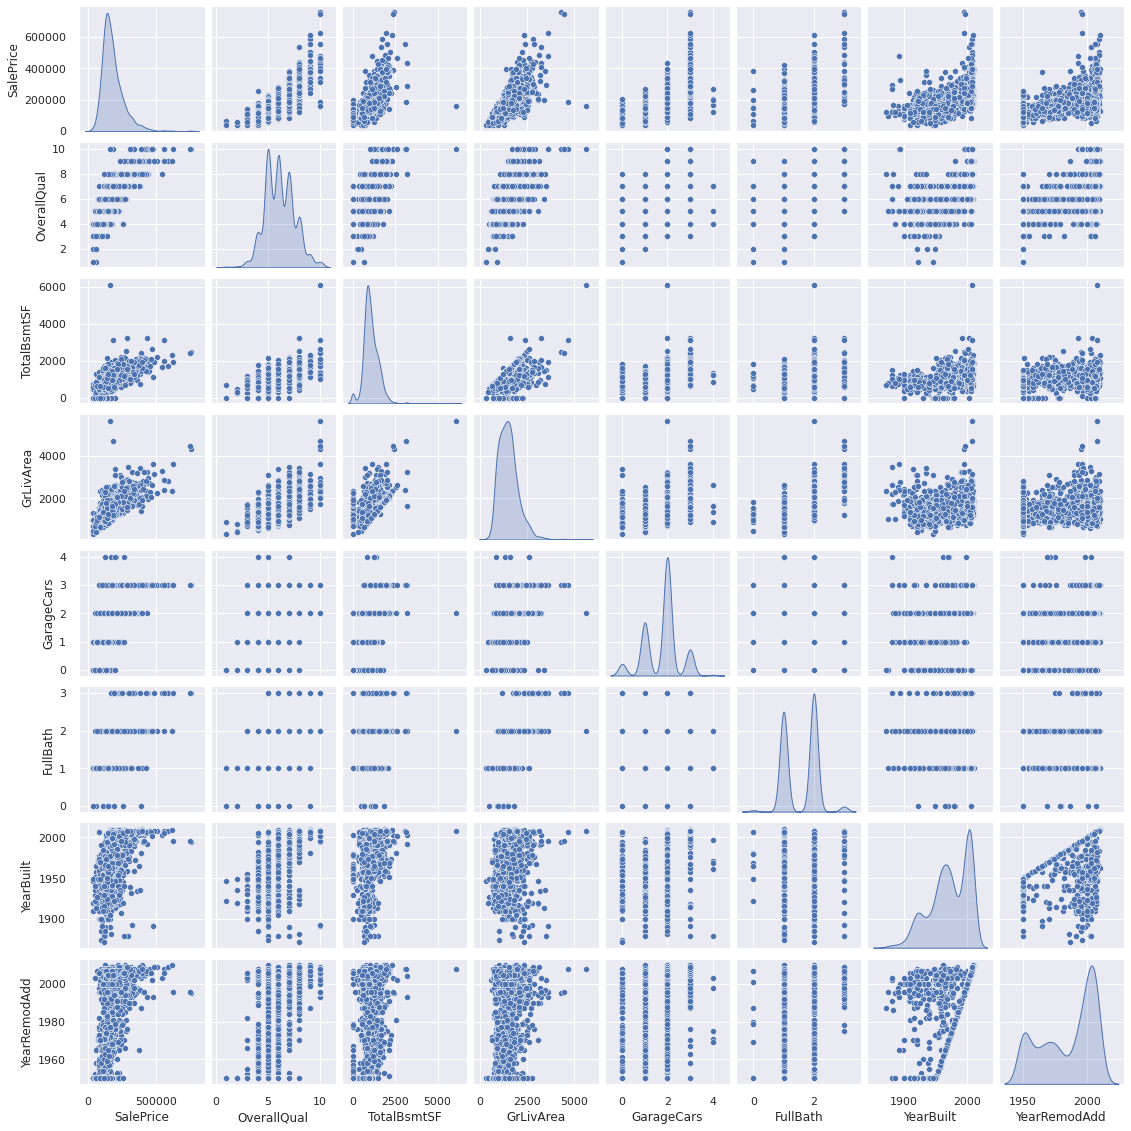

In [17]:
sns.set()
columns=['SalePrice','OverallQual','TotalBsmtSF','GrLivArea','GarageCars','FullBath','YearBuilt','YearRemodAdd']
sns.pairplot(df_train[columns], size=2, kind='scatter', diag_kind='kde')
plt.show()

* 위 Zoomed Heat Map에서 다중 공선성을 보이는 변수 중 SalePrice와 연관이 적은 변수를 제외하고 PairPlot을 그린다.
* 'TotalBsmtSF'와 'GrLivArea'는 데이터 설명에서 알 수 있듯 지하실 면적과 생활 공간 면적을 의미한다.
* 'TotalBsmtSF'와 'GrLivArea'의 plot을 보면 점들이 직선처럼 그려지지 않고 대부분 집은 해당 선 아래에 유지된다. 이는 일반적으로 지하실 면적이 더 크지 않기 때문에 보여지는 특징이다.
* 'SalePrice'와 'YearBuilt'의 plot을 보면 우상향 곡선을 보인다. 이는 전년도 대비 주택 가격 상승의 가속을 의미한다. 

### 4)Scatter Plot

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


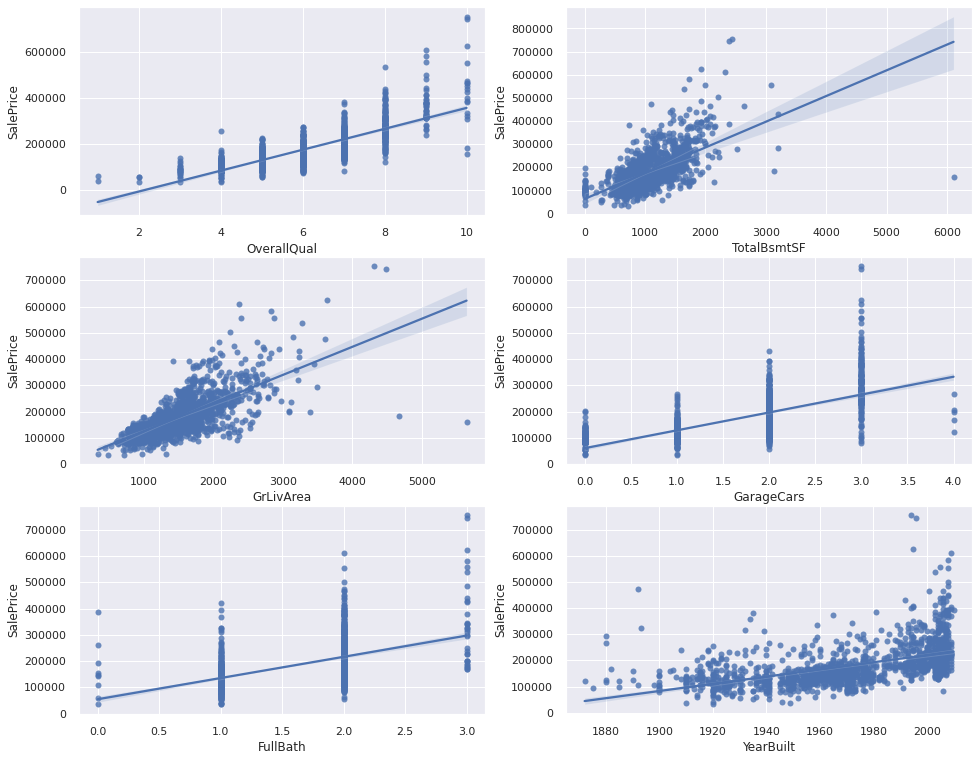

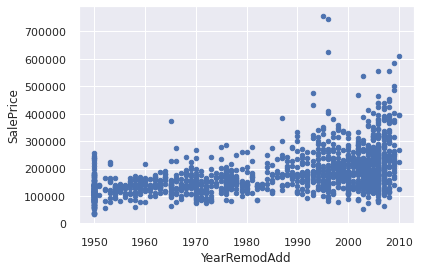

In [18]:
fig,((ax1,ax2),(ax3,ax4),(ax5,ax6))=plt.subplots(nrows=3, ncols=2, figsize=(16,13))
OverallQual_scatter_plot=pd.concat([df_train['SalePrice'],df_train['OverallQual']],axis=1)
sns.regplot(x='OverallQual',y='SalePrice', data=OverallQual_scatter_plot, scatter=True, fit_reg=True, ax=ax1)

TotalBsmtSF_scatter_plot=pd.concat([df_train['SalePrice'],df_train['TotalBsmtSF']],axis=1)
sns.regplot(x='TotalBsmtSF', y='SalePrice',data=TotalBsmtSF_scatter_plot, scatter=True, fit_reg=True, ax=ax2)

GrLivArea_scatter_plot=pd.concat([df_train['SalePrice'],df_train['GrLivArea']],axis=1)
sns.regplot(x='GrLivArea',y='SalePrice',data=GrLivArea_scatter_plot, scatter=True, fit_reg=True, ax=ax3)

GarageCars_scatter_plot=pd.concat([df_train['SalePrice'], df_train['GarageCars']],axis=1)
sns.regplot(x='GarageCars',y='SalePrice',data=GarageCars_scatter_plot, scatter=True, fit_reg=True, ax=ax4)

FullBath_scatter_plot=pd.concat([df_train['SalePrice'],df_train['FullBath']],axis=1)
sns.regplot(x='FullBath',y='SalePrice',data=FullBath_scatter_plot, scatter=True, ax=ax5)

YearBuilt_scatter_plot=pd.concat([df_train['SalePrice'], df_train['YearBuilt']],axis=1)
sns.regplot(x='YearBuilt',y='SalePrice',data=YearBuilt_scatter_plot,scatter=True, ax=ax6)

YearRemodAdd_scatter_plot=pd.concat([df_train['SalePrice'],df_train['YearRemodAdd']],axis=1)
YearRemodAdd_scatter_plot.plot.scatter('YearRemodAdd','SalePrice')

## Categorical Data 탐색
질적 변수를 사용해 두 가지 방법을 구현할 수 있다.  
1. 변수 값과 관련해 SalePrice의 분포를 확인한다.
2. 가능한 범주별로 더미 변수를 만든다.

In [19]:
# 범주형 변수들과 각 범주 확인
for cate in list(categorical_feats):
    print(df_train[cate].value_counts())
    print('#'*50)

RL         1151
RM          218
FV           65
RH           16
C (all)      10
Name: MSZoning, dtype: int64
##################################################
Pave    1454
Grvl       6
Name: Street, dtype: int64
##################################################
Grvl    50
Pave    41
Name: Alley, dtype: int64
##################################################
Reg    925
IR1    484
IR2     41
IR3     10
Name: LotShape, dtype: int64
##################################################
Lvl    1311
Bnk      63
HLS      50
Low      36
Name: LandContour, dtype: int64
##################################################
AllPub    1459
NoSeWa       1
Name: Utilities, dtype: int64
##################################################
Inside     1052
Corner      263
CulDSac      94
FR2          47
FR3           4
Name: LotConfig, dtype: int64
##################################################
Gtl    1382
Mod      65
Sev      13
Name: LandSlope, dtype: int64
############################################

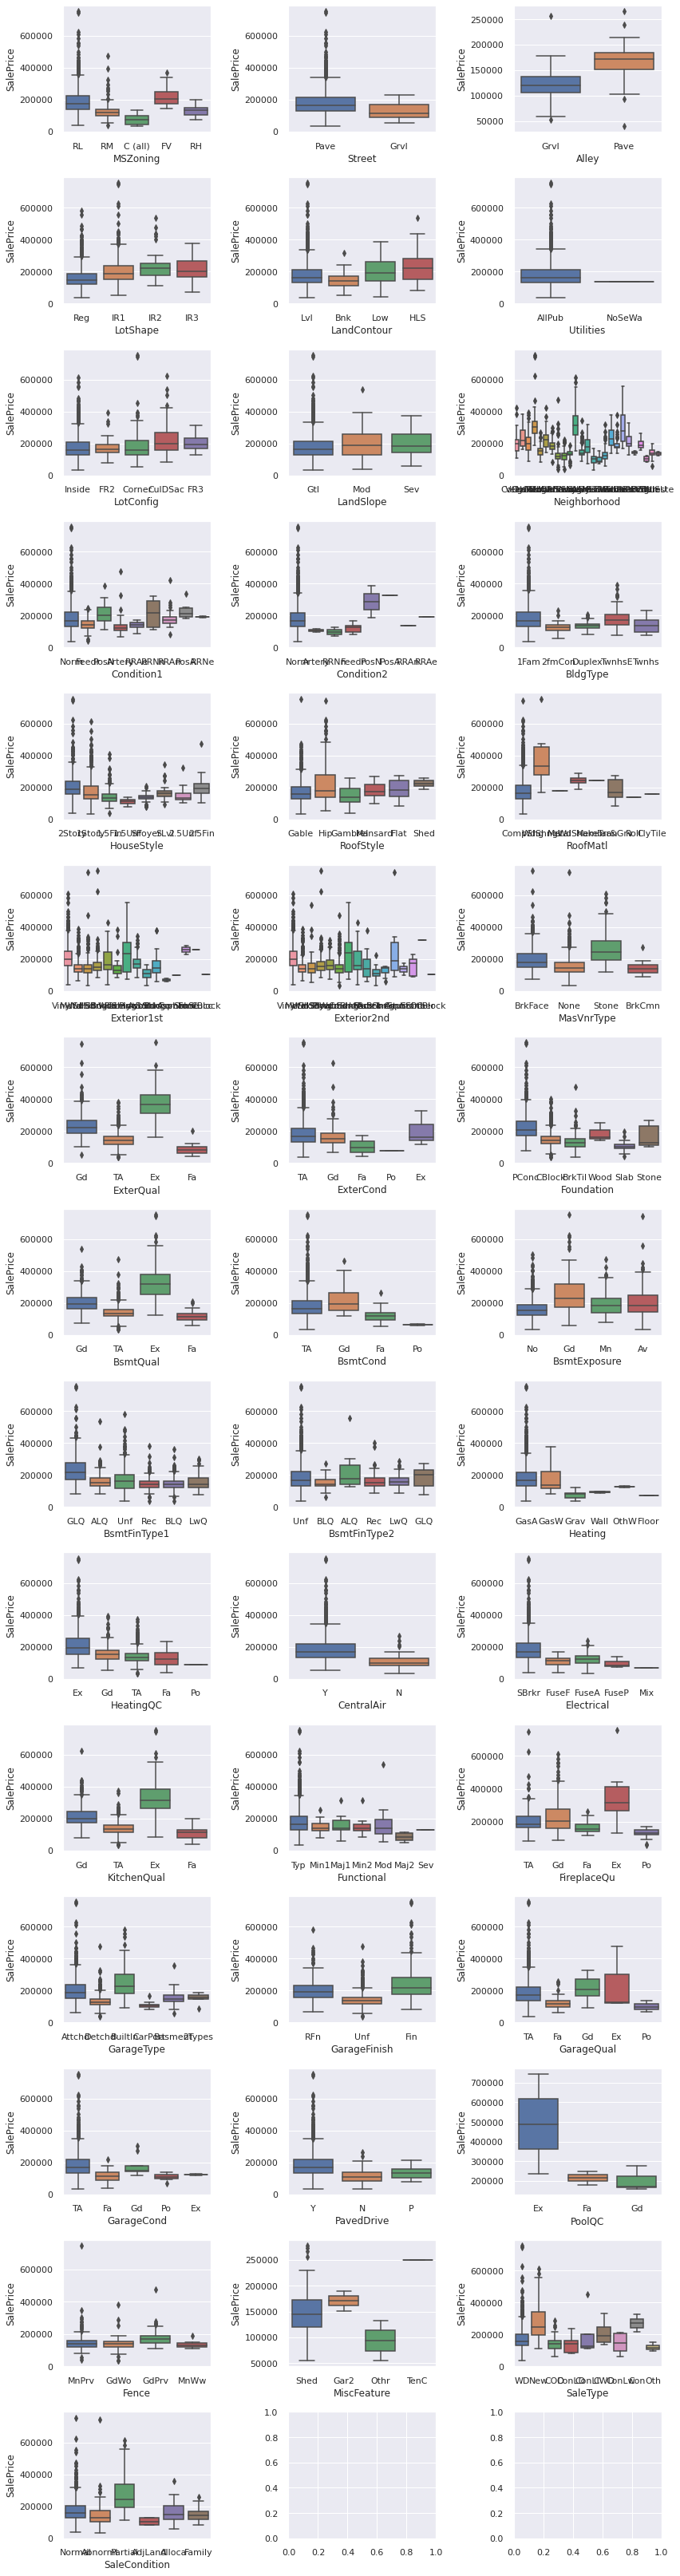

In [20]:
li_cat_feats=list(categorical_feats)
nr_rows=15
nr_cols=3

fig,axs=plt.subplots(nr_rows, nr_cols, figsize=(nr_cols*4, nr_rows*3))

for r in range(0,nr_rows):
    for c in range(0,nr_cols):
      i=r*nr_cols+c
      if i < len(li_cat_feats):
          sns.boxplot(x=li_cat_feats[i], y=df_train['SalePrice'], data=df_train, ax=axs[r][c])

x=axs[r][c]

plt.tight_layout()
plt.show()

Boxplot을 그려 Categorical Feature와 SalePrice의 관계를 확인한다.   
일부 범주는 다른 범주보다 SalePrice와 관련해 더 다양하게 보인다.
* Neighborhood, SaleType 변수는 주택 가격 편차가 매우 크므로 영향이 크다
* 또한 수영장이 있으면 가격기 크게 증가하는 경향을 보인다.
* 정리하자면 SalePrice에 영향을 많이 끼치는 변수로는 'MSZoning', 'Neighborhood', 'Conditino2', 'MasVnrType', 'ExterQual', 'BsmtQual', 'CentraAir', 'Electrical', 'KitchenQual', 'SaleType' 등이 있다.


In [21]:
# 편의를 위해 SalePrice와 관련이 큰 변수와 아닌 변수를 분리한다.
# Id는 submission 때문에 따로 분리한다.
num_strong_corr=['SalePrice','OverallQual','TotalBsmtSF','GrLivArea','GarageCars','FulBath','YearBuilt','YearRemodAdd']

num_weak_corr=['MSSubClass', 'LotFrontage', 'LotArea', 'OverallCond', 'MasVnrArea', 'BsmtFinSF1',
                 'BsmtFinSF2', 'BsmtUnfSF', '1stFlrSF', '2ndFlrSF','LowQualFinSF', 'BsmtFullBath',
                 'BsmtHalfBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd',
                 'Fireplaces', 'GarageYrBlt', 'GarageArea', 'WoodDeckSF','OpenPorchSF',
                 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold']

cate_strong_corr=['MSZoning', 'Neighborhood', 'Condition2', 'MasVnrType', 'ExterQual',
                    'BsmtQual','CentralAir', 'Electrical', 'KitchenQual', 'SaleType','MSZoning', 'Neighborhood', 'Condition2', 'MasVnrType', 'ExterQual',]
                    

cate_weak_corr=['Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 
                  'LandSlope', 'Condition1',  'BldgType', 'HouseStyle', 'RoofStyle', 
                  'RoofMatl', 'Exterior1st', 'Exterior2nd', 'ExterCond', 'Foundation', 
                  'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 
                  'HeatingQC', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 
                  'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature', 
                  'SaleCondition']



# 3.Feature Engineering

## 1)Log 변환

Skewness : 1.882876
Kurtosis : 6.536282


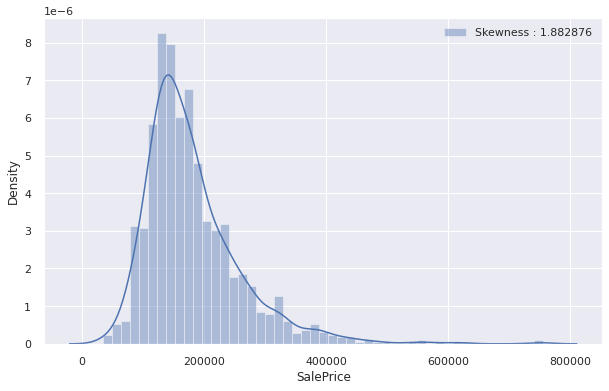

In [22]:
f,ax=plt.subplots(1,1,figsize=(10,6))
g=sns.distplot(df_train['SalePrice'], color='b', label='Skewness : {:2f}'.format(df_train['SalePrice'].skew()), ax=ax)
g=g.legend(loc='best')

print(f"Skewness : {df_train['SalePrice'].skew():.6f}")
print(f"Kurtosis : {df_train['SalePrice'].kurt():.6f}")

* Target Feature인 SalePrice의 비대칭도와 첨도를 확인한다.
* 그래프와 수치르 확인하며 정상적으로 분포되지 않는 것을 확인할 수 있다.
* 예측의 정확도를 높이기 위해 로그 변환 수행.

Skewness : 0.121335
Kurtosis : 0.809532


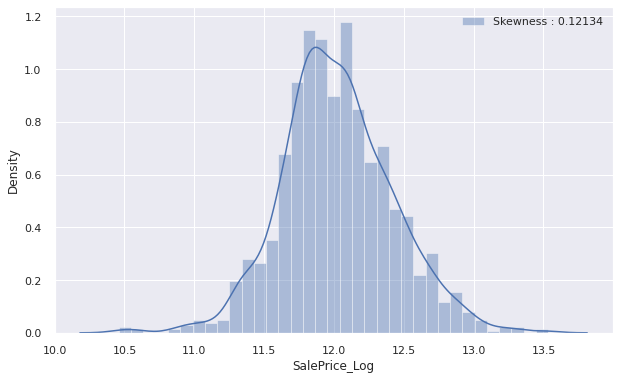

In [23]:
df_train['SalePrice_Log']=df_train['SalePrice'].map(lambda i : np.log(i) if i>0 else 0)

f,ax=plt.subplots(1,1, figsize=(10,6))
g=sns.distplot(df_train['SalePrice_Log'], color='b', label='Skewness : {:.5f}'.format(df_train['SalePrice_Log'].skew(), ax=ax))
g=g.legend(loc='best')

print(f"Skewness : {df_train['SalePrice_Log'].skew():.6f}")
print(f"Kurtosis : {df_train['SalePrice_Log'].kurt():.6f}")

df_train.drop('SalePrice',axis=1, inplace=True)

* Kewness, Kurtosis를 없애주기 위해 로그를 취해준다.
* Log 변환을 수행한 새로운 feature "SalePrice_Log'를 만들고 전 Feature인 'SalePrice'를 버린다.
* 로그를 취해준 그래프와 수치가 바뀐 모습을 볼 수 있다. (정규근사화)

Data Check 과정에서 Skewness와 Kurtosis가 보이는 변수들이 있으나 EDA과정에서 중요하다고 판단되었던 수치형 변수들은  Skewness/Kurtosis가 보이지 않으므로 종속변수인 'SalePrcie'만 Log를 취한다.



## 2)결측치 처리
집 값 예측 문제는 많은 결측치(NaN)이 포함되어 있다. 하지만 변수들의 특징을 보면 이들을 파악할 수 있다.

In [24]:
# NaN을 값이 없다는 의미로 None로 대체한다.
cols_fillna=['PoolQC','MiscFeature','Alley','Fence','MasVnrType','FireplaceQu',
               'GarageQual','GarageCond','GarageFinish','GarageType', 'Electrical',
               'KitchenQual', 'SaleType', 'Functional', 'Exterior2nd', 'Exterior1st',
               'BsmtExposure','BsmtCond','BsmtQual','BsmtFinType1','BsmtFinType2',
               'MSZoning', 'Utilities']

for col in cols_fillna:
    df_train[col].fillna('None', inplace=True)
    df_test[col].fillna('None', inplace=True)

In [25]:
total=df_train.isnull().sum().sort_values(ascending=False)
percent=(df_train.isnull().sum()/df_train.isnull().count()).sort_values(ascending=False)

missing_data=pd.concat([total, percent], axis=1, keys=['Total','Percent'])
missing_data.head(5)

,Total,Percent
LotFrontage,259,0.177397
GarageYrBlt,81,0.055479
MasVnrArea,8,0.005479
SalePrice_Log,0,0.000000
ExterCond,0,0.000000


In [26]:
# 나머지 값은 평균으로 대체한다.
df_train.fillna(df_train.mean(),inplace=True)
df_test.fillna(df_test.mean(),inplace=True)

In [27]:
# 다시 확인해보면 결측치가 사라진 것을 볼 수 있다.
total=df_train.isnull().sum().sort_values(ascending=False)
percent=(df_train.isnull().sum()/df_train.isnull().count()).sort_values(ascending=False)

missing_data=pd.concat([total,percent], axis=1, keys=['Total','Percent'])
missing_data.head(5)

,Total,Percent
SalePrice_Log,0,0.0
Heating,0,0.0
RoofStyle,0,0.0
RoofMatl,0,0.0
Exterior1st,0,0.0


In [28]:
df_train.isnull().sum().sum(), df_train.isnull().sum().sum()

(0, 0)

## 3)유의하지 않은 변수 삭제

In [29]:
# SalePrice와 상관관계 약한 변수 제거
id_tests=df_test['Id']

to_drop_num=num_weak_corr
to_drop_catg=cate_weak_corr

cols_to_drop=['Id']+to_drop_num+to_drop_catg

for df in [df_train,df_test]:
    df.drop(cols_to_drop, inplace=True, axis=1)

df_train.head()

,MSZoning,Neighborhood,Condition2,OverallQual,YearBuilt,YearRemodAdd,MasVnrType,ExterQual,BsmtQual,TotalBsmtSF,CentralAir,Electrical,GrLivArea,FullBath,KitchenQual,GarageCars,SaleType,SalePrice_Log
0,RL,CollgCr,Norm,7,2003,2003,BrkFace,Gd,Gd,856,Y,SBrkr,1710,2,Gd,2,WD,12.247694
1,RL,Veenker,Norm,6,1976,1976,None,TA,Gd,1262,Y,SBrkr,1262,2,TA,2,WD,12.109011
2,RL,CollgCr,Norm,7,2001,2002,BrkFace,Gd,Gd,920,Y,SBrkr,1786,2,Gd,2,WD,12.317167
3,RL,Crawfor,Norm,7,1915,1970,None,TA,TA,756,Y,SBrkr,1717,1,Gd,3,WD,11.849398
4,RL,NoRidge,Norm,8,2000,2000,BrkFace,Gd,Gd,1145,Y,SBrkr,2198,2,Gd,3,WD,12.429216


## 4)Categorical Data 수치형 변환
EDA의 BoxPlot에서 종속변수와 영향이 큰 변수들을 변환한다.

### a.ViolinPlot

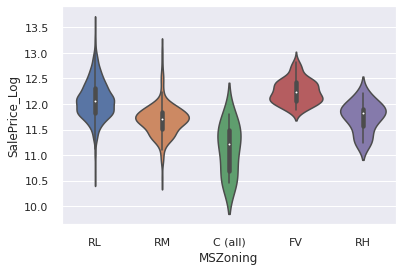

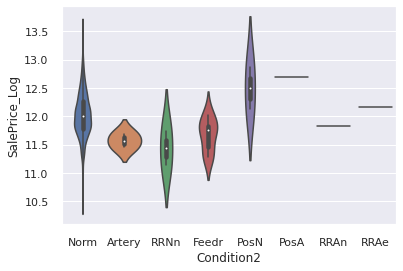

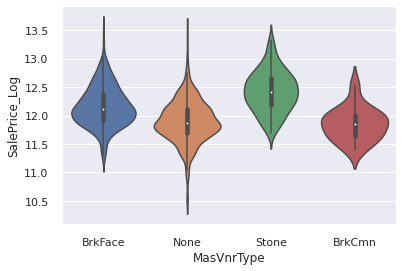

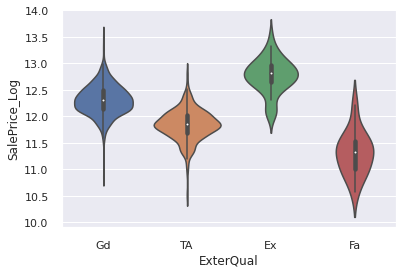

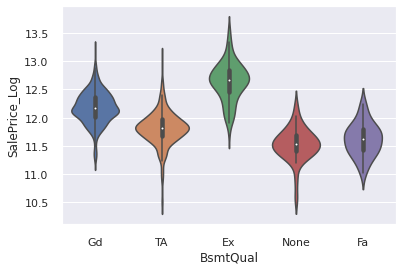

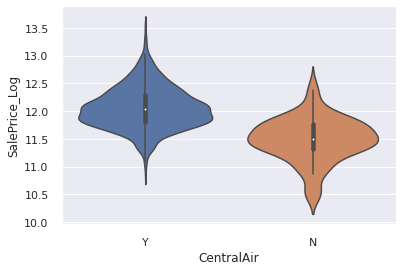

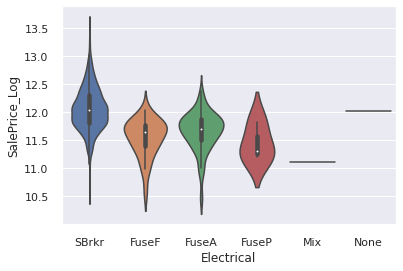

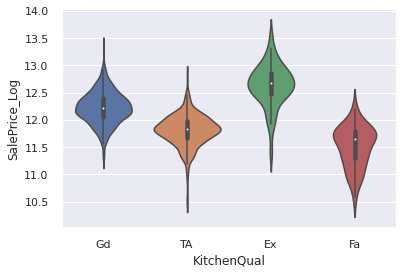

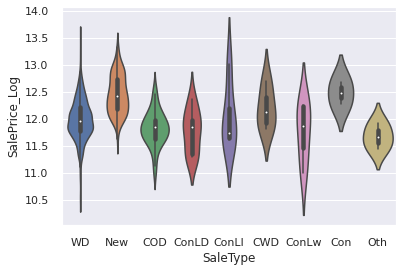

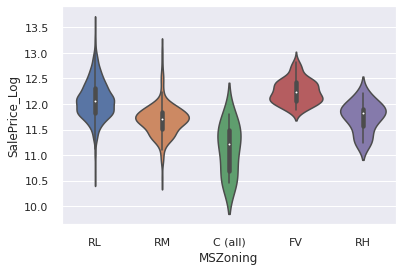

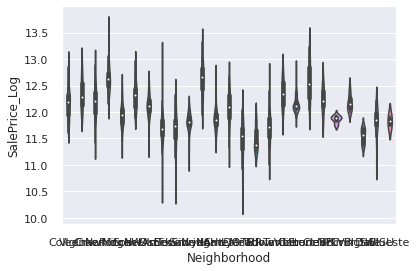

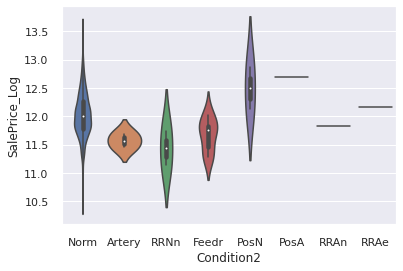

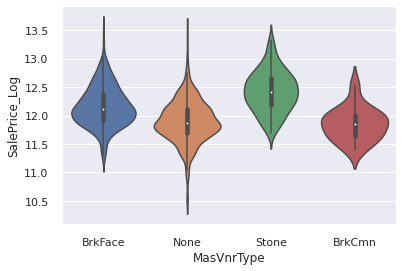

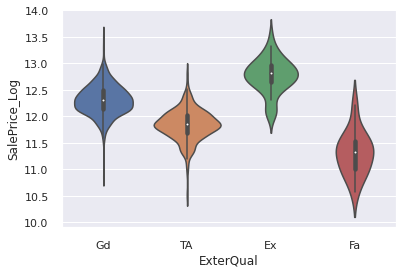

In [52]:
cate_list = cate_strong_corr.copy()
cate_list.remove('Neighborhood')

for cate in cate_list :
    sns.violinplot(x=cate, y=df_train["SalePrice_Log"], data=df_train)
    plt.show()

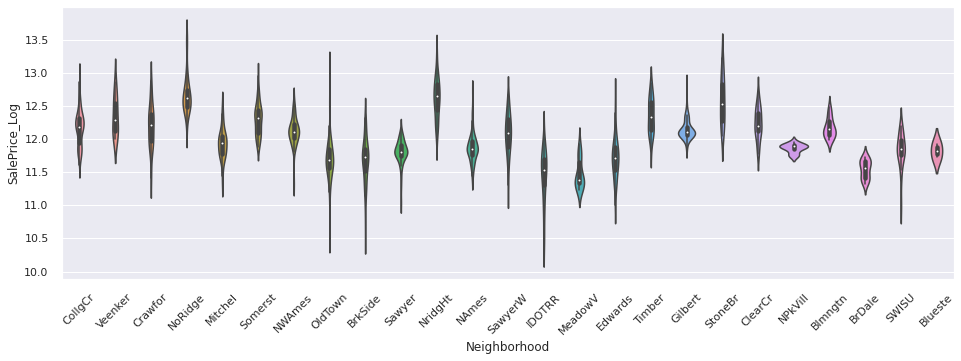

In [33]:
# 범주가 가장 많은 Neighborhood 변수도 확인
fig,ax=plt.subplots()
fig.set_size_inches(16,5)
sns.violinplot(x='Neighborhood', y=df_train['SalePrice_Log'], data=df_train,ax=ax)
plt.xticks(rotation=45)
plt.show()

In [36]:
for cate in cate_list:
    g=df_train.groupby(cate)['SalePrice_Log'].mean()
    print(g)

MSZoning
C (all)    11.118259
FV         12.246616
RH         11.749840
RL         12.085885
RM         11.692893
Name: SalePrice_Log, dtype: float64
Condition2
Artery    11.570036
Feedr     11.670631
Norm      12.025895
PosA      12.691580
PosN      12.493879
RRAe      12.154779
RRAn      11.827043
RRNn      11.435329
Name: SalePrice_Log, dtype: float64
MasVnrType
BrkCmn     11.853239
BrkFace    12.163630
None       11.896884
Stone      12.425138
Name: SalePrice_Log, dtype: float64
ExterQual
Ex    12.764044
Fa    11.304541
Gd    12.311282
TA    11.837985
Name: SalePrice_Log, dtype: float64
BsmtQual
Ex      12.640394
Fa      11.617600
Gd      12.179882
None    11.529680
TA      11.810855
Name: SalePrice_Log, dtype: float64
CentralAir
N    11.491858
Y    12.061090
Name: SalePrice_Log, dtype: float64
Electrical
FuseA    11.660315
FuseF    11.539624
FuseP    11.446808
Mix      11.112448
None     12.028739
SBrkr    12.061464
Name: SalePrice_Log, dtype: float64
KitchenQual
Ex    12.633614
F

In [53]:
# 수치형 변환을 위해 ViolinPlot과 SalePrice 평균을 참고해 범주형 변수들의 값을 그룹화한다.
# 'MSZoning'
msz_cate2=['RM','RH']
msz_cate3=['RL','FV']

# Neighborhood
nbhd_cate2=['Blmngtn','ClearCr','CollgCr','Crawfor','Gilbert','NWAmes','Somerst','Timber','Veenker']
nbhd_cate3=['NoRidge','NridgHt','StoneBr']

# Condition2
cond2_cate2=['Norm','RRAe']
cond2_cate3=['PosA','PosN']

# SaleType
SlTy_cate1=['Oth']
SlTy_cate3=['CWD']
SlTy_cate4=['New','Con']

In [54]:
# 범주형 변수를 수치형으로 변환.
for df in [df_train, df_test]:
    
    df['MSZ_num']=1
    df.loc[(df['MSZoning'].isin(msz_cate2)), 'MSZ_num']=2
    df.loc[(df['MSZoning'].isin(msz_cate3)), 'MSZ_num']=3

    df['NbHd_num']=1
    df.loc[(df['Neighborhood'].isin(nbhd_cate2)),'NbHd_num']=2
    df.loc[(df['Neighborhood'].isin(nbhd_cate3)),'NbHd_num']=3
    
    df['Cond2_num']=1
    df.loc[(df['Condition2'].isin(cond2_cate2)), 'Cond2_num']=2
    df.loc[(df['Condition2'].isin(cond2_cate3)), 'Cond2_num']=3

    df['Mas_num']=1
    df.loc[(df['MasVnrType']=='Stone'), 'Mas_num']=2

    df['ExtQ_num']=1
    df.loc[(df['ExterQual']=='TA'),'ExtQ_num']=2
    df.loc[(df['ExterQual']=='Gd'),'ExtQ_num']=3
    df.loc[(df['ExterQual']=='Ex'),'ExtQ_num']=4
    
    df['BsQ_num']=1
    df.loc[(df['BsmtQual']=='Gd'), 'BsQ_num']=2
    df.loc[(df['BsmtQual']=='Ex'), 'BsQ_num']=3

    df['CA_num']=0
    df.loc[(df['CentralAir']=='Y'), 'CA_num']=1

    df['Elc_num']=1
    df.loc[(df['Electrical']=='SBrkr'), 'Elc_num']=2

    df['KiQ_num']=1
    df.loc[(df['ExterQual']=='TA'),'KiQ_num']=2
    df.loc[(df['ExterQual']=='Gd'),'KiQ_num']=3
    df.loc[(df['ExterQual']=='Ex'),'KiQ_num']=4

    df['SlTy_num']=2
    df.loc[(df['SaleType'].isin(SlTy_cate1)), 'SlTy_num']=1
    df.loc[(df['SaleType'].isin(SlTy_cate3)), 'SlTy_num']=3
    df.loc[(df['SaleType'].isin(SlTy_cate4)), 'SlTy_num']=4

In [48]:
for df in [df_train, df_test]:
    
    df['MSZ_num'] = 1  
    df.loc[(df['MSZoning'].isin(msz_cate2) ), 'MSZ_num'] = 2    
    df.loc[(df['MSZoning'].isin(msz_cate3) ), 'MSZ_num'] = 3        
    
    df['NbHd_num'] = 1       
    df.loc[(df['Neighborhood'].isin(nbhd_cate2) ), 'NbHd_num'] = 2    
    df.loc[(df['Neighborhood'].isin(nbhd_cate3) ), 'NbHd_num'] = 3    

    df['Cond2_num'] = 1       
    df.loc[(df['Condition2'].isin(cond2_cate2) ), 'Cond2_num'] = 2    
    df.loc[(df['Condition2'].isin(cond2_cate3) ), 'Cond2_num'] = 3    
    
    df['Mas_num'] = 1       
    df.loc[(df['MasVnrType'] == 'Stone' ), 'Mas_num'] = 2 
    
    df['ExtQ_num'] = 1       
    df.loc[(df['ExterQual'] == 'TA' ), 'ExtQ_num'] = 2     
    df.loc[(df['ExterQual'] == 'Gd' ), 'ExtQ_num'] = 3     
    df.loc[(df['ExterQual'] == 'Ex' ), 'ExtQ_num'] = 4     
   
    df['BsQ_num'] = 1          
    df.loc[(df['BsmtQual'] == 'Gd' ), 'BsQ_num'] = 2     
    df.loc[(df['BsmtQual'] == 'Ex' ), 'BsQ_num'] = 3     
 
    df['CA_num'] = 0          
    df.loc[(df['CentralAir'] == 'Y' ), 'CA_num'] = 1    

    df['Elc_num'] = 1       
    df.loc[(df['Electrical'] == 'SBrkr' ), 'Elc_num'] = 2 


    df['KiQ_num'] = 1       
    df.loc[(df['KitchenQual'] == 'TA' ), 'KiQ_num'] = 2     
    df.loc[(df['KitchenQual'] == 'Gd' ), 'KiQ_num'] = 3     
    df.loc[(df['KitchenQual'] == 'Ex' ), 'KiQ_num'] = 4      
    
    df['SlTy_num'] = 2       
    df.loc[(df['SaleType'].isin(SlTy_cate1) ), 'SlTy_num'] = 1  
    df.loc[(df['SaleType'].isin(SlTy_cate3) ), 'SlTy_num'] = 3  
    df.loc[(df['SaleType'].isin(SlTy_cate4) ), 'SlTy_num'] = 4 
    

### b.HeatMap

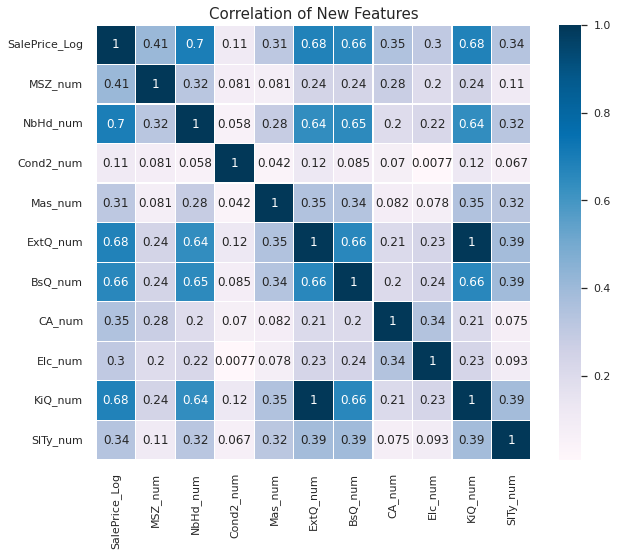

In [55]:
# 변환해 새로 만들어진 수치형 변수들 또한 Heatmap을 그려본다.
# NbHd_num, ExtQ_num, BsQ_num, CA_num, Elc_num, KiQ_num 외 변수는 SalePrice_Log와 큰 상관관계가 없어 보인다.
new_col_HM=df_train[['SalePrice_Log', 'MSZ_num', 'NbHd_num', 'Cond2_num', 'Mas_num', 'ExtQ_num', 'BsQ_num', 'CA_num', 'Elc_num', 'KiQ_num', 'SlTy_num']]

colormap=plt.cm.PuBu
plt.figure(figsize=(10,8))
plt.title("Correlation of New Features",y=1.0, size=15)
sns.heatmap(new_col_HM.corr(), linewidths=.2,vmax=1, square=True, cmap=colormap, linecolor='white',annot=True, annot_kws={"size":12})

In [56]:
# 기존 범주형 변수와 새로 만들어진 수치형 변수 역시 유의하지 않은 것들은 삭제한다. 
df_train.drop(['MSZoning','Neighborhood' , 'Condition2', 'MasVnrType', 'ExterQual', 'BsmtQual','CentralAir', 'Electrical', 'KitchenQual', 'SaleType', 'Cond2_num', 'Mas_num', 'CA_num', 'Elc_num', 'SlTy_num'], axis = 1, inplace = True)
df_test.drop(['MSZoning', 'Neighborhood' , 'Condition2', 'MasVnrType', 'ExterQual', 'BsmtQual','CentralAir', 'Electrical', 'KitchenQual', 'SaleType', 'Cond2_num', 'Mas_num', 'CA_num', 'Elc_num', 'SlTy_num'], axis = 1, inplace = True)

In [57]:
df_train.head() #유의미한 변수만 남김. 

,OverallQual,YearBuilt,YearRemodAdd,TotalBsmtSF,GrLivArea,FullBath,GarageCars,SalePrice_Log,MSZ_num,NbHd_num,Cond_num,ExtQ_num,BsQ_num,KiQ_num
0,7,2003,2003,856,1710,2,2,12.247694,3,2,2.0,3,2,3
1,6,1976,1976,1262,1262,2,2,12.109011,3,2,2.0,2,2,2
2,7,2001,2002,920,1786,2,2,12.317167,3,2,2.0,3,2,3
3,7,1915,1970,756,1717,1,3,11.849398,3,2,2.0,2,1,2
4,8,2000,2000,1145,2198,2,3,12.429216,3,3,2.0,3,2,3


In [59]:
df_test.head() 

,OverallQual,YearBuilt,YearRemodAdd,TotalBsmtSF,GrLivArea,FullBath,GarageCars,MSZ_num,NbHd_num,Cond_num,ExtQ_num,BsQ_num,KiQ_num
0,5,1961,1961,882.0,896,1,1.0,2,1,2.0,2,1,2
1,6,1958,1958,1329.0,1329,1,1.0,3,1,2.0,2,1,2
2,5,1997,1998,928.0,1629,2,2.0,3,2,2.0,2,2,2
3,6,1998,1998,926.0,1604,2,2.0,3,2,2.0,2,1,2
4,8,1992,1992,1280.0,1280,2,2.0,3,3,2.0,3,2,3


# 4.Modeling & make submission
**Model : XGBssot**

## Valid Set

### 1) Data Split

In [63]:
from sklearn.model_selection import train_test_split
from sklearn import metrics

X_train=df_train.drop("SalePrice_Log", axis=1).values
target_label=df_train['SalePrice_Log'].values
X_test=df_test.values

X_tr, X_vld, y_tr, y_vld = train_test_split(X_train, target_label, test_size=0.2, random_state=2000)

### 2)modeling(xgb)

In [64]:
# xgboost 모델 생성
import xgboost
regressor=xgboost.XGBRegressor(colample_bytree=0.4603, learnig_rate=0.06, min_child_weight=1.8, max_depth=3, subsample=0.52, n_estimator=2000,
                               random_state=7, nthread=-1)

regressor.fit(X_tr, y_tr)

[07:06:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colample_bytree=0.4603,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             gamma=0, importance_type='gain', learnig_rate=0.06,
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1.8, missing=None, n_estimator=2000,
             n_estimators=100, n_jobs=1, nthread=-1, objective='reg:linear',
             random_state=7, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=0.52, verbosity=1)

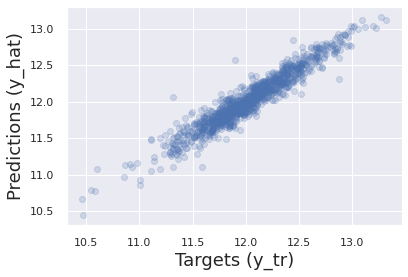

In [70]:
# 예측된 y값(y_hat)에 대한 scatter plot 생성
y_hat=regressor.predict(X_tr)

plt.scatter(y_tr, y_hat, alpha=0.2)
plt.xlabel('Targets (y_tr)',size=18)
plt.ylabel('Predictions (y_hat)', size=18)
plt.show()

In [71]:
regressor.score(X_tr, y_tr)

0.9140854313168897

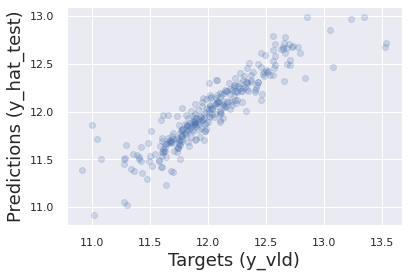

In [73]:
# validation으로 예측
y_hat_test=regressor.predict(X_vld)

plt.scatter(y_vld, y_hat_test, alpha=0.2)
plt.xlabel('Targets (y_vld)', size=18)
plt.ylabel('Predictions (y_hat_test)', size=18)
plt.show()

In [74]:
regressor.score(X_vld, y_vld)

0.8353593229791038

### 3)k-fold

In [76]:
from sklearn.model_selection import cross_val_score
accuracy=cross_val_score(estimator=regressor, X=X_tr, y=y_tr, cv=10)

[07:15:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[07:15:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[07:15:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[07:15:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[07:15:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[07:15:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[07:15:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[07:15:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

In [77]:
# 정확도 확인
print(accuracy.mean())
print(accuracy.std())

0.8580321001084525
0.047491339108585266


### 4)submission

In [ ]:
use_logvals=1
pred_xgb=regressor.predict(X_test)

sub_xgb=pd.DataFrame()
sub_xgb['Id']=id_testssub_xgb['SalePrice']=pred_xgb

if use_logvals==1:
    sub_xgb['SalePrice']=np.exp(sub_xgb['SalePrice'])

sub_xgb.to_csv('xgb.csv',index=False)

* use_logvlas는 Log를 취해준 Target 변수 지수곱을 위해 사용되는 스위치 역할이다. 
* 제대로 된 예측을 위해 학습 후 Log변환을 풀어줘야 한다.  
이 셀의 코드를 통해 submission까지 완료.